# Bias in income prediction - Responsible AI analysis sandbox

### By Gleb Drobkov - BCG Responible AI

## Introduction

#### This notebook analyzes income and demographic data to understand drivers of prospertiy and income growth.

Data description details can be found at the link below: <br>
https://docs.google.com/document/d/1RVYKlNVE5pepIYnt645VSrWf_cPOJNBVhoWNKXRbKdk/edit?usp=sharing

Analysis sections of this notebook: <br>
0. Import packages, all standard + BCG RAI tool
1. Read data and apply filters / clean-ups
2. Build historical features
3. Sample data and prepare features
4. Measure historic and model bias and accuracy

# 0. Imports

In [1]:
# Import analysis libraries
import time
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scipy.stats.mstats as mstats

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, metrics, model_selection, svm

from seaborn import load_dataset
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import shap

# from notebooks/ directory
import sys, os

# Python settings
pd.set_option('display.max_columns', None)

# 1. Read data and apply filters / clean-ups

In [2]:
def read_in_income(gz_path):
    ## Download input file from BCG Egnyte - RAI folder
    ## https://bcg01.egnyte.com/navigate/folder/881ba5c2-8f6e-4eb6-b940-848faa78dee9
    ipums = pd.read_csv(gz_path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False,
                       usecols = ['INCTOT','SEX','AGE','YEAR','MET2013','RACE','HISPAN','EDUC','MARST',
                                 'SERIAL', 'CBSERIAL', 'HHTYPE'])

    print(ipums.shape)
    # The data contains information about individuals' income, education and demographic background
    return(ipums)

##### Read in MSA names

In [3]:
def read_in_msa_info():
    ipums_metro = pd.read_csv('./data/ipums_metro_code_to_name.csv')
    
    # 295 unique metro areas
#     print(len(ipums_metro.MET2013.unique()))
    
    return ipums_metro

# 2. Create historical features

##### Filter down to working age (18-80) records for which we have income

In [4]:
def clean_age_income(model_input):
    # Focus only on records 2013-2020
    model_input = model_input[model_input['YEAR'] >= 2013]    
    # Remove unemployed people
    model_input = model_input[model_input['INCTOT'] != 9999999]
    # Remove volunteer workers with no income
    model_input = model_input[model_input['INCTOT'] > 0]
    # Remove non-working age people - chose to inclue 80+ age people
    model_input = model_input[model_input['AGE'] > 18]
#     model_input = model_input[model_input['AGE'] < 80]
    return(model_input)

#### Some inequality is merited (for ex. by age / tenue) -- we create segments to control for this disparity

In [5]:
def create_age_groupings(model_input):
    #### Group based on age
    conditions = [
        (model_input.AGE >= 18) & (model_input.AGE < 26), # 1
        (model_input.AGE >= 26) & (model_input.AGE < 36), # 2
        (model_input.AGE >= 36) & (model_input.AGE < 46), # 3
        (model_input.AGE >= 46) & (model_input.AGE < 56), # 4
        (model_input.AGE >= 56) & (model_input.AGE < 66), # 5
        (model_input.AGE >= 66) # 6
    ]

    choices = ['1 - 18-25', '2 - 26-35', '3 - 36-45', 
               '4 - 46-55', '5 - 56-65', '6 - 65+']
    model_input['AGE_Grp'] = np.select(conditions, choices, default='Other Age')
        
    return(model_input)

#### Some inequality is driven by historical biases (for ex. by age / tenue) -- we create segments to interrogate this disparity

In [6]:
def create_race_groupings(model_input):
    #### Group based on US Census race definitions

    # Group 1: Asian
    # Group 2: White, not Hispanic
    # Group 3: Hispanic (any race)
    # Group 4: Black

    # by group
    conditions = [
        (model_input.RACE == 4) | (model_input.RACE == 5) | (model_input.RACE == 6),
        (model_input.RACE == 1) & (model_input.HISPAN == 0),
        (model_input.HISPAN == 1),
        (model_input.RACE == 2)
    ]

    choices = ['Asian', 'White not Hispanic', 'Hispanic any race', 'Black']
    model_input['RACE_Grp'] = np.select(conditions, choices, default='Other race')
    
    # adding indicators for bias analysis later - binary
    model_input['non_white'] = 1 - np.where(model_input['RACE_Grp'] == 'White not Hispanic',1,0)
    model_input['hispanic'] = np.where(model_input['RACE_Grp'] == 'Hispanic any race',1,0)
    model_input['black'] = np.where(model_input['RACE_Grp'] == 'Black',1,0)
    
    return(model_input)

In [7]:
def generate_median_income_plot(model_input):
    
    income_df = model_input[['RACE_Grp','YEAR', 'INCTOT']]
    
    # Calculate mean income by among protected groups by year
    group_pg_year = income_df.groupby(['RACE_Grp','YEAR']).describe().stack(level=0)[['50%','mean']]
    group_pg_year = group_pg_year.reset_index()

    ### The data from IPUMS differs vs. the Census chart above presumably due to household vs. individual level
    income_plot = group_pg_year[['RACE_Grp', 'YEAR', 'mean','50%']]
    income_plot = income_plot.pivot(index='YEAR', columns='RACE_Grp', values='mean')
    income_plot.plot( figsize=(12, 6))

#### Gini Coefficient


In [8]:
def gini_calc(v):
    
    # Credit where due to user user12446118
    # Link: https://stackoverflow.com/questions/31416664/gini-coefficient-calculation-using-numpy
    
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

In [9]:
# Define 1st inequality metric - Gini coefficient
def ineq_metric_extractor(model_input, group_cols, target, train_test_split_year):
        # Subset historical training period
        model_input_historical = model_input[model_input['YEAR'] < train_test_split_year]

        # Define gini runner
        def gini_coef(income_array):
            bins, result, gini_val = gini_calc(income_array)
            return gini_val
        
        def percentile(n):
            def percentile_(x):
                return np.percentile(x, n)
            percentile_.__name__ = 'percentile_%s' % n
            return percentile_
        
        # Calculate percentiles 
        out_stats = (model_input_historical.groupby(group_cols)[target]
               .agg([np.mean, percentile(25),percentile(50), percentile(75), 
                     percentile(90), percentile(95), percentile(99), gini_coef]))
        
        out_stats = out_stats.reset_index()
        out_stats.columns = ['_'.join(col).strip() for col in out_stats.columns.values]
        
        return(out_stats)

##### Create MSA-level features

In [10]:
def msa_extractor(model_input,group_cols, median_targets, mean_targets, train_test_split_year):
    # Subset historical training period
    model_input_historical = model_input[model_input['YEAR'] < train_test_split_year]

    median_df = pd.DataFrame(model_input_historical.groupby(group_cols)[median_targets].median())
    median_df = median_df.reset_index()
    median_df.columns = ['MET2013','msa_INCTOT','msa_AGE']

    mean_df = pd.DataFrame(model_input_historical.groupby(group_cols)[mean_targets].mean())
    mean_df = mean_df.reset_index()
    mean_df.columns = ['MET2013','msa_hispanic_density']
    
    summary_df = median_df.merge(mean_df, left_on = 'MET2013', right_on = 'MET2013', how = 'left')
        
    return(summary_df)

In [11]:
def join_msa_stats(ipums_metro, model_input,out_stats, msa_summary_df):
    # # Left join all metro area names
    ipums_metro.columns = ['MET2013','MSA']

    # create modeling data frame with individial income
    income_df = model_input.merge(ipums_metro, left_on = 'MET2013', right_on = 'MET2013', how = 'left')

    # Join MSA level stats prior to train/test period
    income_df = income_df.merge(msa_summary_df, left_on = 'MET2013', right_on = 'MET2013', how = 'left')
    income_df = income_df.merge(out_stats, left_on = 'MET2013', right_on = 'MET2013_', how = 'left')
    
    return(income_df)

# 3. Sample data and prepare model

#### Target (Y): 
- Y1 - Individual is in the 50th percentile income, or above
- Y2 - Individual is in the 95th percentile income, or above

#### Explanatory variables (X - at individual / YEAR level - prior four years): <br>
- X1 - Age (Grouped)
- X2 - Education
- X3 - Marital Status
- X4a - MSA - income
- X4b - MSA - avg age
- X4c - MSA - hispanic density
- X4d - MSA - Gini Coeefficient

#### We do not look at an individuals year-over-year income in this analysis - the model has no individual-level historical income data, only aggregated at the MSA (geographic) level. All variables available:

### Clean up data - standardize education and marital status

In [12]:
def ipums_model_prep(model_sample,num_vars,cat_vars, dep_bin):
    
    model_sample['EDUC'] = (model_sample['EDUC'].isin([10,11])).astype('int')
    filt = model_sample['EDUC'] == 1
    model_sample.loc[filt, 'EDUC'] = 'college'
    model_sample.loc[~filt, 'EDUC'] = 'no_college'
    
    model_sample['MARST'] = (model_sample['MARST'].isin([1,2])).astype('int')
    filt = model_sample['MARST'] == 1
    model_sample.loc[filt, 'MARST'] = 'married'
    model_sample.loc[~filt, 'MARST'] = 'not_married'
    
    # Option to scale all the inputs, decided to keep unscaled for interpretability
#     model_data_norm = normalize_num(model_sample, num_vars)
    model_data_cat = pd.get_dummies(model_sample[cat_vars])
    model_data_num = model_sample[num_vars]
    model_data = pd.concat([model_sample[[dep_bin]], model_data_cat, model_data_num], axis=1)
    
    return(model_data)

In [13]:
def ipums_sample(income_df, pg_vars, sample_size, train_test_split_year):

    # Sample and subset years for training
    model_sample = income_df[income_df['YEAR'] < train_test_split_year]
    model_sample = model_sample.sample(n=sample_size, random_state=42)

    # Take PG vars for future bias measurement
    pg_sample = model_sample[pg_vars]
    pg_sample['SEX'] = np.where(pg_sample.SEX == 2, 1, 0)
    
    return(pg_sample, model_sample)

##### Create a binary indicator - 95th percentile income

In [14]:
def model_prepare(model_data, pg_sample, dep_var_binary, outcome_rate):
    # Create a binary indicator - 95th percentile income
    model_data_2 = model_data.copy()
    model_data_2['high_income'] = np.where(model_data_2.INCTOT > np.percentile(model_data_2.INCTOT,100-outcome_rate),1,0)
    
    model_data_2 = model_data_2.drop(labels=dep_var, axis=1)

    X = model_data_2.drop(labels=dep_var_binary, axis=1)

    y = model_data_2[dep_var_binary]

    # Split - pg_sample too for measurement
    X_train, X_val, y_train, y_val,pg_train,pg_val = train_test_split(X,y,pg_sample,train_size=.8, random_state=42)
    
    return(X_train, X_val, y_train, y_val, y, pg_train,pg_val, model_data_2)

##### Define models to run

In [15]:
def model_build(X_train, X_val, y_train, y_val):
    # RF model params
    params = {
        "n_estimators": 50,
        "max_depth": 5,
        "random_state": 777,
        "class_weight": "balanced",
    }

    # Model 1: Logit
    logit_full = LogisticRegression(class_weight = "balanced", random_state = 777)
    logit_full.fit(X_train, y_train)

    # Model 2: RF
    rf_full = RandomForestClassifier(**params)
    rf_full.fit(X_train, y_train)

    # Model 3: LGBM
    lg_full = LGBMClassifier(max_depth=3, n_estimators=1000, objective="binary")
    lg_full.fit(X_train,y_train, eval_set=(X_val,y_val), early_stopping_rounds=100, verbose=100) 
    
    return(logit_full,rf_full,lg_full)

# 4. Measure historic and model bias and accuracy

##### Measure historical bias

In [16]:
def historic_bias(y, pg_sample, pg_vars, dep_var_binary):
    bias_msmt_input = pd.DataFrame([])

    bias_msmt_input = pg_sample[pg_vars]
    bias_msmt_input['high_income'] = y

    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    hisp = bias_msmt_input[['hispanic', 'high_income']].groupby(['hispanic']).mean()
    sex = bias_msmt_input[['SEX', 'high_income']].groupby(['SEX']).mean()
    non_white = bias_msmt_input[['non_white', 'high_income']].groupby(['non_white']).mean()
    black = bias_msmt_input[['black', 'high_income']].groupby(['black']).mean()
    
    # if we needed the average outcome rates combining across categories, we would use
    # bias_msmt_input.groupby(['hispanic', 'SEX','non_white','black'])['high_income'].mean()
    
    # Instead we us binary - yes / no
    hist_bias_stats = [sex['high_income'][0],sex['high_income'][1],
                   non_white['high_income'][0],non_white['high_income'][1],
                   black['high_income'][0],black['high_income'][1],
                   hisp['high_income'][0],hisp['high_income'][1]]

    return(bias_msmt_input, hist_bias_stats)

##### Measure model bias - out of sample

In [17]:
def model_bias(X_val,y_val, pg_val, pg_vars, dep_var_binary, clf, outcome_rate):

    bias_msmt_val = X_val.copy()
    bias_msmt_val = pg_val[pg_vars]
    bias_msmt_val['high_income'] = y_val
    
    # Convert ranked scores into threshold for cutoff - selection of those who will receive offer
    outcome_rate_thresh = np.percentile(clf.predict_proba(X_val)[::,1], 100 - pd.to_numeric(outcome_rate))

    bias_msmt_val['high_income_pred'] = np.where(clf.predict_proba(X_val)[::,1] > outcome_rate_thresh,1,0)


    # Read mean outcome rates for 0 and 1 - Non-PG and PG
    pred_black = bias_msmt_val[['black', 'high_income_pred']].groupby(['black']).mean()
    pred_hisp = bias_msmt_val[['hispanic', 'high_income_pred']].groupby(['hispanic']).mean()
    pred_female = bias_msmt_val[['SEX', 'high_income_pred']].groupby(['SEX']).mean()
    pred_nonwhite = bias_msmt_val[['non_white', 'high_income_pred']].groupby(['non_white']).mean()
    
    pred_bias_stats = [pred_female['high_income_pred'][0], pred_female['high_income_pred'][1],
                       pred_nonwhite['high_income_pred'][0], pred_nonwhite['high_income_pred'][1],
                       pred_black['high_income_pred'][0], pred_black['high_income_pred'][1],
                       pred_hisp['high_income_pred'][0], pred_hisp['high_income_pred'][1]]
                       
    
    return(bias_msmt_val, pred_bias_stats)

##### Measure model performance

In [18]:
def model_scenario(X_val,y_val,dep_var_binary, outcome_rate, clf):
    # Calculate AUC
    y_pred_proba = clf.predict_proba(X_val)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
    auc = metrics.roc_auc_score(y_val, y_pred_proba)
    # Calculate Jaccard Accuracy
    acc = metrics.accuracy_score(y_val, clf.predict(X_val))

    # Convert ranked scores into threshold for cutoff - selection of those who will receive offer
    outcome_rate_thresh = np.percentile(clf.predict_proba(X_val)[::,1], 100 - pd.to_numeric(outcome_rate))

    #### Update here
    cm_percent = pd.crosstab(np.where(clf.predict_proba(X_val)[::,1] >= outcome_rate_thresh,1,0),y_val
                            ).apply(lambda r: r/r.sum(), axis=1)

    model_stats = [auc, acc,
                   outcome_rate/100,
                   cm_percent[1][1],
                   cm_percent[1][1]/(outcome_rate/100)]

    
    return(model_stats)


##### Append outputs into a dataset for all years run

In [19]:
def append_stats(model_df,model_stats):
    # clea model stats / year to DF
    clean_stats = pd.DataFrame(model_stats)
    # append to df for all years in run
    model_df = pd.concat([model_df,clean_stats], axis=1)
    return(model_df)

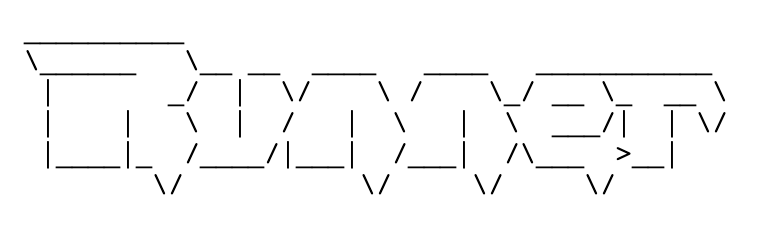

# Runner - all functions

##### Run once, load data, ~8 min on old (2021) macbook pro for ~3 GB file

In [20]:
gz_path = './data/usa_00005.csv.gz'

ipums_select = read_in_income(gz_path)

(109658177, 12)


##### Set all the parameters -- training / testing years will run through a loop, 2017-2020

In [21]:
##### Set parameters for feature engineering
# Set parameters
train_test_split_year = 2016
group_cols = ['MET2013']

# for gini and ptiles fn
target = ['INCTOT']

# for mean and median fn
median_targets = ['INCTOT', 'AGE']
mean_targets = ['hispanic']

##### Set parameters for classification model
dep_var_binary = 'high_income'

# Set all model target and input variables
id_var = ['SERIAL']
split_var = ['YEAR']
dep_var = ['INCTOT']
dep_bin = 'INCTOT'   

# Define numeric and categorical variables
pg_vars = ['non_white', 'hispanic', 'black', 'SEX']
num_vars = ['msa_INCTOT', 'msa_AGE','msa_hispanic_density', 'INCTOT_gini_coef']
cat_vars = ['AGE_Grp','EDUC','MARST', 'RACE_Grp']

# to make the model super discrimantory, include
# 'RACE_Grp'
# 'msa_hispanic_density'

sample_size = 100000

# Assign a binary indicator to the highest X% of model scores - these are the proxy group
outcome_rate = 5


In [22]:
def run_all_ipums_fns(ipums_select,
                     train_test_split_year,
                    group_cols,
                    target,
                    median_targets,
                    mean_targets,
                    dep_var_binary,
                    id_var,
                    split_var,
                    dep_var,
                    dep_bin,
                    pg_vars,
                    num_vars,
                    cat_vars,
                    sample_size,
                    outcome_rate):
    
    # Run data clean up functions
    ipums_metro = read_in_msa_info()

    model_input = clean_age_income(ipums_select)
    model_input = create_age_groupings(model_input)
    model_input = create_race_groupings(model_input)

    # (Optional) Show results in same format as US Census
    # generate_median_income_plot(model_input)

    ##### Run feature engineering functons
    out_stats = ineq_metric_extractor(model_input, group_cols, target, train_test_split_year)
    msa_summary_df = msa_extractor(model_input,group_cols, median_targets, mean_targets, train_test_split_year)
    income_df = join_msa_stats(ipums_metro, model_input,out_stats, msa_summary_df) 
    
    ##### Run model prep functions
    pg_sample, model_sample = ipums_sample(income_df, pg_vars, sample_size, train_test_split_year)
    model_data = ipums_model_prep(model_sample,num_vars,cat_vars, dep_bin)

    ##### Build models and measure bias / performance
    X_train, X_val, y_train, y_val,y, pg_train,pg_val,model_data_binary = model_prepare(model_data, 
                                                                                pg_sample,
                                                                                dep_var_binary,
                                                                                outcome_rate)
    logit_full,rf_full,lgbm_full = model_build(X_train, X_val, y_train, y_val)

    ##### Output bias results + historical pg/non-pg rates
    bias_msmt_input, hist_bias_stats = historic_bias(y, pg_sample, pg_vars, dep_var_binary)
    bias_msmt_val, pred_bias_stats = model_bias(X_val,y_val, pg_val, pg_vars, dep_var_binary,lgbm_full,outcome_rate)

    ##### Output model performance metrics 
    model_stats = model_scenario(X_val,y_val,dep_var_binary, outcome_rate,rf_full)
    
    run_mode = [train_test_split_year,
            group_cols,
            target,
            median_targets,
            mean_targets,
            dep_var_binary,
            id_var,
            split_var,
            dep_var,
            dep_bin,
            pg_vars,
            num_vars,
            cat_vars,
            sample_size,
            outcome_rate]

    print(run_mode)
    
    return(run_mode,hist_bias_stats, pred_bias_stats, model_stats, income_df)

# Run for all years 2017-2020

In [23]:
train_test_split_years = [2017,2018,2019,2020]

In [24]:
run_df = pd.DataFrame([])
hist_df = pd.DataFrame([])
pred_df = pd.DataFrame([])
model_df = pd.DataFrame([])

for train_test_split_year in train_test_split_years:
    
    run_mode, hist_bias_stats, pred_bias_stats, model_stats, income_df = run_all_ipums_fns(ipums_select,
                                                         train_test_split_year,
                                                         group_cols,
                                                         target,
                                                         median_targets,
                                                         mean_targets,
                                                         dep_var_binary,
                                                         id_var,
                                                         split_var,
                                                         dep_var,
                                                         dep_bin,
                                                         pg_vars,
                                                         num_vars,
                                                         cat_vars,
                                                         sample_size,
                                                         outcome_rate)
    
    run_df = append_stats(run_df,run_mode)
    hist_df = append_stats(hist_df,hist_bias_stats)
    pred_df = append_stats(pred_df,pred_bias_stats)
    model_df = append_stats(model_df,model_stats)


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.154051
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.153998
[2017, ['MET2013'], ['INCTOT'], ['INCTOT', 'AGE'], ['hispanic'], 'high_income', ['SERIAL'], ['YEAR'], ['INCTOT'], 'INCTOT', ['non_white', 'hispanic', 'black', 'SEX'], ['msa_INCTOT', 'msa_AGE', 'msa_hispanic_density', 'INCTOT_gini_coef'], ['AGE_Grp', 'EDUC', 'MARST', 'RACE_Grp'], 100000, 5]
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.158051
[200]	valid_0's binary_logloss: 0.158198
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.158021
[2018, ['MET2013'], ['INCTOT'], ['INCTOT', 'AGE'], ['hispanic'], 'high_income', ['SERIAL'], ['YEAR'], ['INCTOT'], 'INCTOT', ['non_white', 'hispanic', 'black', 'SEX'], ['msa_INCTOT', 'msa_AGE', 'msa_hispanic_density', 'INCTOT_gini_coef'], ['AGE_Grp', 'EDUC', 'MARST', 'RACE_Grp'], 100000, 5]
Training until valid

#### Combine all DFs in a run

In [25]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [27]:
# hist_df = hist_df.drop('Incl',axis=1)

In [28]:
def stats_comparison(stats_df):
    
    stats_df.columns = train_test_split_years
    stats_df['Incl'] = [0,1,0,1,0,1,0,1]

    return(stats_df)

In [29]:
def bias_all(hist_df,pred_df):
    
    hist_df_clean = stats_comparison(hist_df)
    pred_df_clean = stats_comparison(pred_df)
    
    hist_pg = hist_df_clean[hist_df_clean['Incl'] == 1]
    pred_pg = pred_df_clean[pred_df_clean['Incl'] == 1]

    hist_pg = hist_pg.select_dtypes(include=np.number)
    pred_pg = pred_pg.select_dtypes(include=np.number)

    bias_pg = pred_pg/hist_pg
    bias_pg['Group'] = ['Sex','Non-W','Hisp','Black']

    return(bias_pg, hist_df_clean, pred_df_clean)

In [30]:
bias_pg, hist_df_clean, pred_df_clean = bias_all(hist_df,pred_df)

In [31]:
hist_df_clean

,2017,2018,2019,2020,Incl
0,0.07520,0.07225,0.07505,0.07516,0
1,0.02543,0.02507,0.02511,0.02501,1
2,0.05767,0.05625,0.05764,0.05748,0
3,0.03054,0.02899,0.03003,0.03088,1
4,0.05357,0.05207,0.05309,0.05322,0
5,0.01632,0.01431,0.01835,0.01818,1
6,0.05278,0.05117,0.05233,0.05247,0
7,0.01188,0.01317,0.01610,0.01473,1


In [32]:
pred_df_clean

,2017,2018,2019,2020,Incl
0,0.05450,0.05534,0.05382,0.05400,0
1,0.04507,0.04465,0.04632,0.04308,1
2,0.05970,0.06151,0.06324,0.06028,0
3,0.02507,0.02158,0.01550,0.02040,1
4,0.05464,0.05527,0.05507,0.05341,0
5,0.00365,0.00000,0.00054,0.00398,1
6,0.05342,0.05377,0.05374,0.05188,0
7,0.00072,0.00069,0.00140,0.00417,1


In [33]:
bias_pg

,2017,2018,2019,2020,Incl,Group
1,1.77222,1.78102,1.84453,1.72274,1.00000,Sex
3,0.82063,0.74434,0.51615,0.66063,1.00000,Non-W
5,0.22356,0.00000,0.02929,0.21910,1.00000,Hisp
7,0.06051,0.05278,0.08687,0.28313,1.00000,Black


# Tableau Extract - MSA - Year - PG

#### Run for 1 year - 2017

In [ ]:
# train_test_split_year = 2017

# run_mode, hist_bias_stats, pred_bias_stats, model_stats, income_df = run_all_ipums_fns(ipums_select,
#                                                          train_test_split_year,
#                                                          group_cols,
#                                                          target,
#                                                          median_targets,
#                                                          mean_targets,
#                                                          dep_var_binary,
#                                                          id_var,
#                                                          split_var,
#                                                          dep_var,
#                                                          dep_bin,
#                                                          pg_vars,
#                                                          num_vars,
#                                                          cat_vars,
#                                                          sample_size,
#                                                          outcome_rate)

##### Create indicator

In [ ]:
# # income_df['high_income'] = np.where(model_input['INCTOT'] == 'Hispanic any race',1,0)
# income_df.columns

##### Create gini and other percentiles info

In [ ]:
# # Define gini runner
# def gini_coef(income_array):
#     bins, result, gini_val = gini_calc(income_array)
#     return gini_val

# def percentile(n):
#     def percentile_(x):
#         return np.percentile(x, n)
#     percentile_.__name__ = 'percentile_%s' % n
#     return percentile_# 


# hisp = income_df[['hispanic','YEAR', 'MSA','INCTOT']].groupby(['YEAR','MSA','hispanic']).mean()


In [ ]:
# # Define group columns
# group_cols = ['SEX','YEAR', 'MSA']

# # Calculate percentiles 
# out_stats = (income_df.groupby(group_cols)[target]
#        .agg([np.mean, percentile(25),percentile(50), percentile(75), 
#              percentile(90), percentile(95), percentile(99), gini_coef]))

# out_stats = out_stats.reset_index()
# out_stats.columns = ['_'.join(col).strip() for col in out_stats.columns.values]

# out_stats.head()

# # sex = income_df[['SEX','YEAR', 'MSA','high_income']].groupby(['YEAR','MSA','SEX']).mean()
# # non_white = income_df[['non_white', 'YEAR','MSA', 'high_income']].groupby(['YEAR','MSA','non_white']).mean()

In [ ]:
# out_stats.to_csv('Tableau Exhibit 2 - Gender Pay Disparity.csv')